# W02 · Perceptron & Multilayer Perceptrons

**Learning objectives**

- Review the limitations of single-layer perceptrons and motivate deeper architectures.
- Practice reasoning about when to add layers versus adding more neurons to existing layers.
- Compare common activation functions and recognize how they influence optimization dynamics.
- Build intuition for diagnosing underfitting/overfitting when designing multilayer perceptrons (MLPs).

## Recap: From Perceptrons to MLPs

In Week 01 we trained a single dense layer on Fashion-MNIST. The perceptron learned a linear decision boundary over flattened pixels.

> **Key limitation:** Without hidden layers the model cannot express interactions between pixels. Decision boundaries remain linear, so patterns like curves, textures, or hierarchical shapes are hard to capture.

To move beyond linear separability we introduce **hidden layers**. Each additional layer composes nonlinear transformations that can
model progressively more abstract features. However, deeper networks add more parameters and optimization challenges, so we need a principled way to decide when to deepen versus widen a network.

## Heuristics for Adding Layers or Neurons

When designing an MLP, consider the following heuristics:

- **Problem complexity**: If your features interact in hierarchical ways (e.g., strokes composing clothing items), adding layers can help. If interactions are mostly linear, widening layers might suffice.
- **Bias vs. variance**:
  - High bias / underfitting → add layers or neurons, or change activations to increase capacity.
  - High variance / overfitting → reduce layers/neurons, add regularization, or collect more data.
- **Representation bottlenecks**: Too few neurons in a critical layer can restrict information flow. Gradually increase width while monitoring validation metrics.
- **Training dynamics**: Vanishing gradients or slow convergence could mean the architecture or activation is poorly matched; try `relu` or `elu` for deeper stacks, or add normalization.
- **Parameter budget / inference cost**: Deeper and wider networks cost more to train/serve. Aim for the simplest model that meets your performance target.

## Setup: Imports & Data Pipeline

We will reuse the Fashion-MNIST dataset from Week 01. To keep experiments fast, we'll train on a 12k-image subset and hold out 2k examples for validation.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time

print(tf.__version__)

# Load Fashion-MNIST
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0, 1]
train_images = train_images.astype("float32") / 255.0 # floating is adopted here to keep precision of data.
test_images = test_images.astype("float32") / 255.0

# Flatten inputs for dense networks
train_images = train_images.reshape(-1, 28 * 28)
test_images = test_images.reshape(-1, 28 * 28) # the shape of test images must be same as train images

# Create train/validation split (12k train / 2k val)
val_split = 2000 # validation set.
train_subset = 12000

train_x = train_images[:train_subset]
train_y = train_labels[:train_subset]
val_x = train_images[train_subset:train_subset + val_split]
val_y = train_labels[train_subset:train_subset + val_split]

class_names = [ # from the 10 classes of fashion mnist
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print(f"Training subset: {train_x.shape}, Validation subset: {val_x.shape}")

2.15.0
Training subset: (12000, 784), Validation subset: (2000, 784)


## Comparing Architectures: Depth vs. Width

We'll train several `tf.keras.Sequential` models that vary in depth (number of hidden layers) and width (neurons per layer). Each model trains for a small number of epochs so we can compare validation performance quickly.

Training model: shallow_wide (1 hidden layer, wide)
Epoch 1/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6669 - loss: 0.9469 - val_accuracy: 0.8220 - val_loss: 0.4987
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8245 - loss: 0.5000 - val_accuracy: 0.8415 - val_loss: 0.4395
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8393 - loss: 0.4559 - val_accuracy: 0.8375 - val_loss: 0.4499
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8572 - loss: 0.4094 - val_accuracy: 0.8535 - val_loss: 0.4006
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8700 - loss: 0.3688 - val_accuracy: 0.8505 - val_loss: 0.4038
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8695 - loss: 0.3573 - val_accuracy: 0.8555 - val_loss: 0.3997
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8719 - loss: 0.3456 - val_accuracy: 0.8615 - val_loss: 0.3764
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.

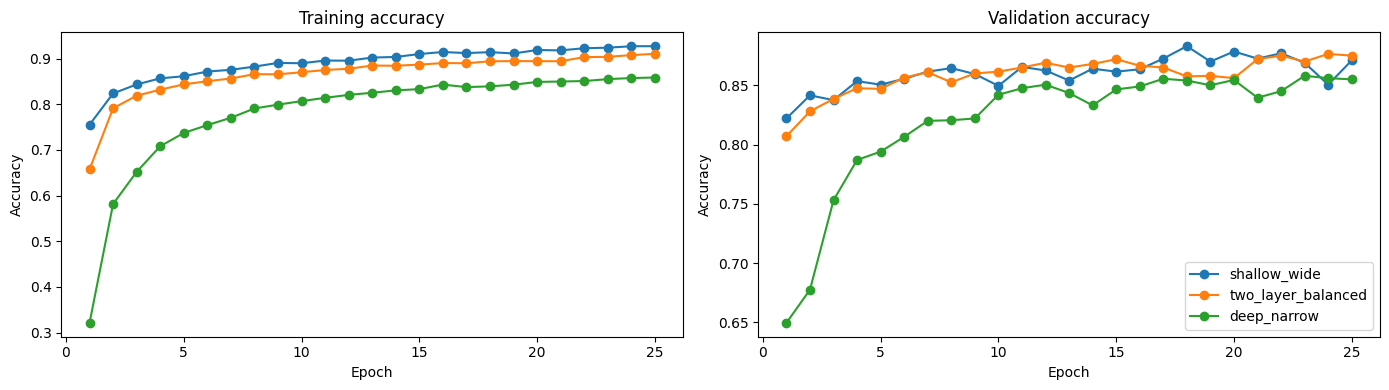

In [3]:
def build_mlp(hidden_layers, activation="relu", dropout_rate=0.0, learning_rate=1e-3):
    model = keras.Sequential(name="mlp")
    model.add(layers.Input(shape=(28 * 28,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), # keep it aside
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

architectures = [ # we are building 3 different models.
    ("shallow_wide", [1024], "1 hidden layer, wide"),
    ("two_layer_balanced", [256, 128], "2 hidden layers"),
    ("deep_narrow", [128, 128, 64, 64, 32], "5 hidden layers, narrower"),
]

histories = {}
training_summaries = []

for model_key, hidden_layers, description in architectures: # 3 times (for loop over the architectures)
    print(f"Training model: {model_key} ({description})")
    model = build_mlp(hidden_layers, dropout_rate=0.3)
    start_time = time.perf_counter() # start time
    history = model.fit( # for later on visualization
        train_x,
        train_y,
        validation_data=(val_x, val_y),
        epochs=25,
        batch_size=128,
        verbose=1 # to turn on the logs put verbose=1
    )
    elapsed = time.perf_counter() - start_time # end counter - timing of fitting/validation
    histories[model_key] = history.history
    val_acc = history.history["val_accuracy"][-1]
    training_summaries.append({
        "model": model_key,
        "description": description,
        "val_accuracy": val_acc,
        "train_time_sec": elapsed,
    })
    print(f"Final validation accuracy: {val_acc:.3f} (time: {elapsed:.2f}s)")

if training_summaries:
    print("Architecture comparison summary:")
    header = f"{'Model':<20}{'Description':<30}{'Val Accuracy':<15}{'Train Time (s)':<15}"
    print(header)
    print('-' * len(header))
    for summary in training_summaries:
        print(
            f"{summary['model']:<20}{summary['description']:<30}"
            f"{summary['val_accuracy']:<15.3f}{summary['train_time_sec']:<15.2f}"
        )

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for model_key, history in histories.items():
    epochs = range(1, len(history["accuracy"]) + 1)
    axes[0].plot(epochs, history["accuracy"], marker="o", label=model_key)
    axes[1].plot(epochs, history["val_accuracy"], marker="o", label=model_key)

axes[0].set_title("Training accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")

axes[1].set_title("Validation accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
plt.tight_layout()
plt.show()


In [4]:
from dl_utils import visualize_model
visualize_model(model)

WindowsPath('model.png')

### Discussion

- How quickly does each architecture reach strong validation accuracy?
- Which model shows signs of underfitting (low training + validation accuracy)?
- Do any models hint at overfitting (training accuracy increases while validation plateaus or drops)?

Use these observations to reason about when additional layers help versus when simply widening a single layer is enough.

## Underfitting vs. Overfitting in Practice

Architecture decisions can go wrong in both directions. We'll contrast a tiny network that lacks capacity with a very deep, wide network trained for longer without regularization to show how training and validation metrics diverge.

In [5]:

extreme_configs = [ # extreme architectures
    ("underfit_tiny", [4], "Tiny capacity (underfitting)"), # 4 neurons in 1 single hidden layer
    ("overfit_huge", [1024, 512, 512, 256, 256, 128, 128], "Deep and wide (overfitting)"),
]

extreme_histories = {}
for key, hidden_layers, description in extreme_configs:
    print(f"Training extreme model: {description}")
    model = build_mlp(hidden_layers, dropout_rate=0.0) # added dropout layer
    history = model.fit(
        train_x,
        train_y,
        validation_data=(val_x, val_y),
        epochs=25,
        batch_size=128,
        verbose=1
    )
    extreme_histories[key] = history.history
    final_train = history.history['accuracy'][-1]
    final_val = history.history['val_accuracy'][-1]
    print(f"Final train acc: {final_train:.3f}, val acc: {final_val:.3f}")


Training extreme model: Tiny capacity (underfitting)
Epoch 1/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2522 - loss: 2.1173 - val_accuracy: 0.4240 - val_loss: 1.6334
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4190 - loss: 1.5955 - val_accuracy: 0.5105 - val_loss: 1.3408
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5159 - loss: 1.3101 - val_accuracy: 0.5785 - val_loss: 1.1130
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6019 - loss: 1.0693 - val_accuracy: 0.6855 - val_loss: 0.9058
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6992 - loss: 0.8823 - val_accuracy: 0.7230 - val_loss: 0.7688
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7327 - loss: 0.7708 - val_accuracy: 0.7415 - val_loss: 0.7155
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7483 - loss: 0.7263 - val_accuracy: 0.7610 - val_loss: 0.6866
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7

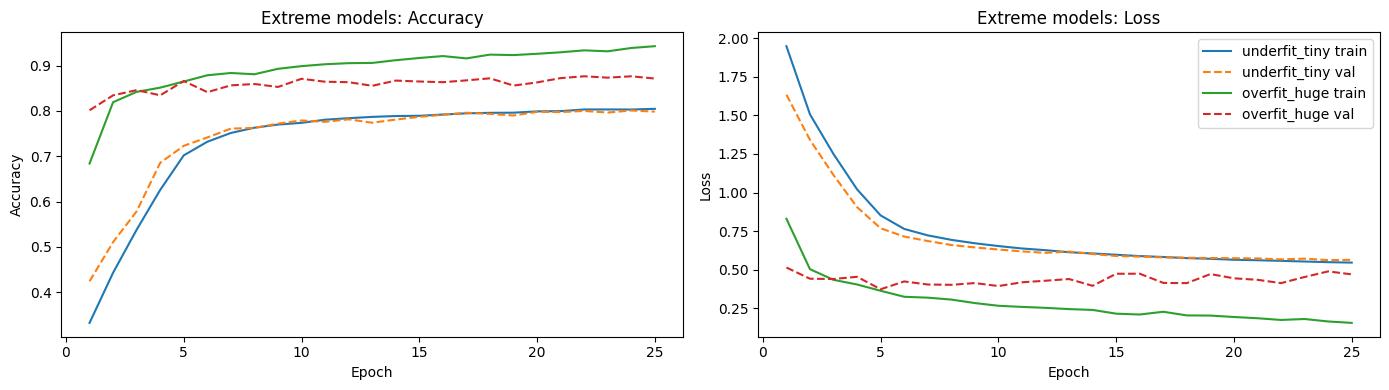

In [6]:

def plot_history_curves(histories, title_prefix=""):
    metrics = [("accuracy", "Accuracy"), ("loss", "Loss")]
    fig, axes = plt.subplots(1, len(metrics), figsize=(14, 4))
    for ax, (metric, display_name) in zip(axes, metrics):
        for key, history in histories.items():
            epochs = range(1, len(history[metric]) + 1)
            ax.plot(epochs, history[metric], label=f"{key} train")
            ax.plot(epochs, history[f'val_{metric}'], linestyle='--', label=f"{key} val")
        ax.set_title(f"{title_prefix}{display_name}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(display_name)
    handles, labels = axes[-1].get_legend_handles_labels()
    axes[-1].legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

plot_history_curves(extreme_histories, title_prefix="Extreme models: ")


### What do we observe?

- **Underfit tiny network**: Training and validation accuracy stay low and the losses remain high, which tells us the model doesn't have enough capacity to represent the patterns in Fashion-MNIST.
- **Overfit huge network**: Training accuracy keeps climbing while validation accuracy plateaus and validation loss rises, showing the model memorizes the training subset but generalizes poorly.
- **Takeaway**: Effective architectures balance depth and width with regularization. Too few layers underfit, while an overpowered network without safeguards quickly overfits.


## Activation Function Experiments

Activations control how information flows between layers. We'll keep a two-layer architecture fixed and vary the nonlinearities to see how they impact convergence and final accuracy.

Training activation variant: relu
Epoch 1/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6450 - loss: 1.0220 - val_accuracy: 0.8290 - val_loss: 0.4681
Epoch 2/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8311 - loss: 0.4715 - val_accuracy: 0.8495 - val_loss: 0.4317
Epoch 3/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8514 - loss: 0.4099 - val_accuracy: 0.8360 - val_loss: 0.4298
Epoch 4/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8738 - loss: 0.3594 - val_accuracy: 0.8560 - val_loss: 0.3749
Epoch 5/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8803 - loss: 0.3292 - val_accuracy: 0.8550 - val_loss: 0.3898
Epoch 6/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8811 - loss: 0.3092 - val_accuracy: 0.8450 - val_loss: 0.4187
Epoch 7/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8928 - loss: 0.2923 - val_accuracy: 0.8580 - val_loss: 0.3803
Epoch 8/25
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8976 - loss: 0.2718 

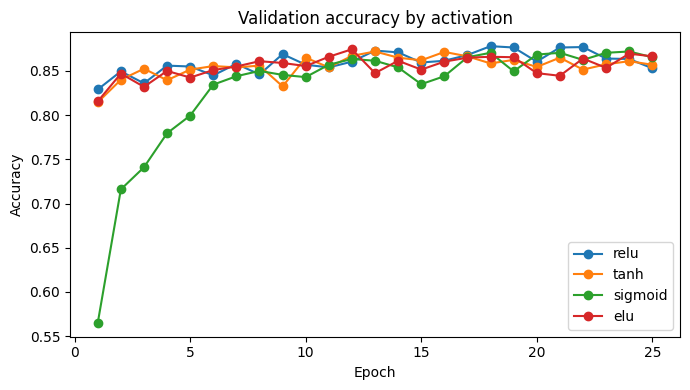

In [9]:
activations = ["relu", "tanh", "sigmoid", "elu"]
activation_histories = {}
for act in activations:
    print(f"Training activation variant: {act}")
    model = build_mlp([512, 256, 256, 128], activation=act) # balanced/narrow case
    start_time = time.perf_counter()
    history = model.fit(
        train_x,
        train_y,
        validation_data=(val_x, val_y),
        epochs=25,
        batch_size=128,
        verbose=1
    )
    elapsed_time = time.perf_counter() - start_time
    activation_histories[act] = history.history
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.3f} - {elapsed_time:.2f}s")

plt.figure(figsize=(7, 4))
for act, history in activation_histories.items():
    epochs = range(1, len(history["val_accuracy"]) + 1)
    plt.plot(epochs, history["val_accuracy"], marker="o", label=act)
plt.title("Validation accuracy by activation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### Activation Takeaways & Assignments

- `relu` (and variants like `elu`) often accelerate training in deeper networks because they mitigate vanishing gradients.
- Saturating activations (`sigmoid`, `tanh`) can struggle without careful initialization or normalization but may still perform competitively with fewer layers.
- Observe whether activations converge to similar validation accuracy despite different training trajectories.

> **Try it:** Mix activations across layers (e.g., first layer `relu`, second `tanh`) and see how the dynamics change.

## Guided Exercises

1. **Architecture tuning**: Modify `architectures` to include a very small network (e.g., `[64]`) and a very deep one (e.g., six layers). Compare validation accuracy and discuss bias/variance trade-offs.
2. **Regularization challenge**: Extend the new underfitting/overfitting section by adding dropout, `layers.BatchNormalization()`, or early stopping to the overfitting model. How much can you shrink the validation gap?
3. **Activation sweep**: Experiment with `swish` (`tf.nn.swish`) or `gelu`. You can pass a callable to the `activation` argument.
4. **TensorBoard logging (optional)**: Wrap training with `keras.callbacks.TensorBoard(log_dir="runs/week02")` to visualize losses and gradients. Record at least one screenshot of your TensorBoard scalars.
5. **Reflection**: For each experiment, note (a) the architecture, (b) activation(s), and (c) final training/validation accuracy. Summarize which design choices worked best and why.


## Week 02 Summary Table

| Section | Focus | Key Takeaways |
| --- | --- | --- |
| Learning Objectives | Goals for the lab | Understand perceptron limitations, experiment with MLP depth/width, and practice diagnosing model capacity issues. |
| Data Preparation | Fashion-MNIST setup | Normalize, flatten, and create train/validation splits to enable rapid architecture experiments. |
| Architecture Comparison | Narrow vs. balanced vs. wide MLPs | Observe how layer depth and width influence convergence speed, accuracy, and runtime. |
| Underfitting vs. Overfitting | Extreme architectures | Contrast tiny and deep-unregularized networks to see bias/variance trade-offs in metrics. |
| Activation Function Experiments | Nonlinearity sweep | Evaluate ReLU, tanh, sigmoid, and ELU to highlight their impact on training dynamics. |
| Guided Exercises | Practice extensions | Encourage further tuning, regularization, and logging to consolidate Week 02 concepts. |

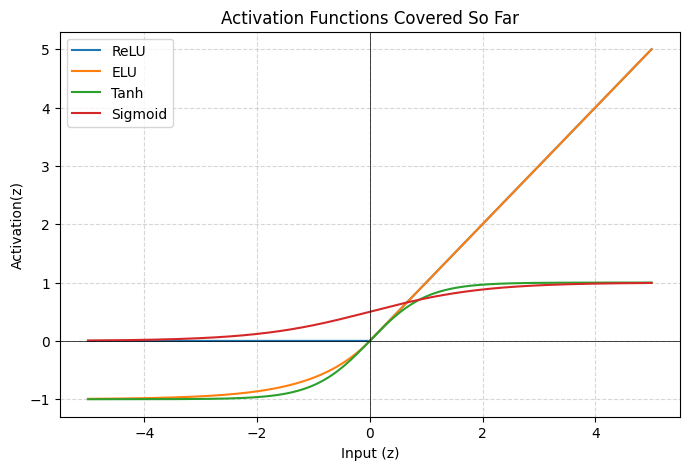

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

z = np.linspace(-5, 5, 400)
activations = {
    "ReLU": tf.nn.relu(z),
    "ELU": tf.nn.elu(z),
    "Tanh": tf.nn.tanh(z),
    "Sigmoid": tf.nn.sigmoid(z),
}

plt.figure(figsize=(8, 5))
for name, values in activations.items():
    plt.plot(z, values, label=name)
plt.title("Activation Functions Covered So Far")
plt.xlabel("Input (z)")
plt.ylabel("Activation(z)")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Activation Function Reference

| Activation | Equation | When to reach for it |
| --- | --- | --- |
| **ReLU** | $f(z) = \max(0, z)$ | Baseline choice in `build_mlp`; keeps gradients alive in deeper MLP stacks so they train quickly. |
| **ELU** | $f(z) = \begin{cases} z, & z > 0 \\ \alpha(e^{z}-1), & z \le 0 \end{cases}$ | Smooth extension of ReLU that also alleviates vanishing gradients while allowing negative outputs. |
| **tanh** | $f(z) = \tanh(z) = \dfrac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$ | Saturating activation; works best in the shallower, variants when initialization and normalization are tuned. |
| **Sigmoid** | $f(z) = \sigma(z) = \dfrac{1}{1+e^{-z}}$ | Another saturating option; expect slower convergence unless you pair it with supportive initialization/normalization. |
